# Demo 10 - Intro to PyTorch

Previously, we've been using `numpy` to do mathematical calculations and make our statistical machine learning models run quickly. But now, we'll be looking at neural networks, where we will want to mostly calculate lots and lots of neurons. Since our neurons are usually in the form $f(x) = h(wx + b)$ we tend to deal with __large matrix multiplications__ (as well as additions, etc...). Since our standard method of training is SGD, with mini-batches, we want to do these matrix multiplications across our whole batch, and the fastest way to do that is in __parallel__. The best hardware for that isn't the CPU we're used to working with but a __GPU!__ There are a number of libraries that are useful for creating neural networks and running them on GPU (Keras/Tensorflow, Chainer,...) but we will be using `PyTorch` (version 0.4.1 at this time)

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58128000 @  0x7fd8ffaec2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [2]:
%pylab inline
import torch
print(torch.__version__)

Populating the interactive namespace from numpy and matplotlib
0.4.1


## PyTorch Tensors

Whereas `numpy` used `np.array` as the basic data structure, in `PyTorch` we will use the similar `torch.Tensor` which you can think of in the same way. The big difference is that `torch.Tensor` can also be moved to the GPU, where they use a library called `CUDA` under the hood to do calculations

In [13]:
a = torch.Tensor([1,2,3])
W = torch.randn(3,3)
b = torch.Tensor([4,5,6]).view(3,1)
print(W.mm(b))

tensor([[-19.6813],
        [  3.9409],
        [  6.3966]])


In [15]:
device = torch.device('cuda:0')    # we use 0 to specify the first GPU
a = a.to(device)
b = b.to(device)
c = torch.ones(3, device=device)
print(a + b + c)

tensor([[ 6.,  7.,  8.],
        [ 7.,  8.,  9.],
        [ 8.,  9., 10.]], device='cuda:0')


## Iris Classification in PyTorch

Let's load  `iris.txt` using the `sklearn` library, we can then preprocess the labels and convert them to one hot encoding

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

iris = datasets.load_iris()

# separate into train/test using sklearn
(x_train, x_test, y_train, y_test) = train_test_split(iris.data, iris.target)

num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_features = x_train.shape[1]
num_classes = 3

# lets also convert our targets y to a one-hot encoding 
# e.g. 1 -> [0, 1, 0], 2 -> [0, 0 ,1]  
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
y_train = one_hot.fit_transform(y_train.reshape(-1,1))
y_test = one_hot.transform(y_test.reshape(-1,1))

Finally, we'll convert our data to `torch.Tensor` representations, and because we can only have operations between arguments of the same type so lets make everything a `float` as well

In [ ]:
x_train = torch.from_numpy(x_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

Now let's implement the logistic regression with gradient descent that we've used before, using the  mean squared loss for simplicity

Text(0,0.5,'mean squared error')

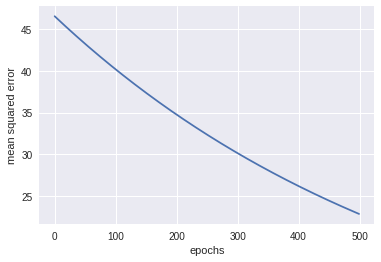

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# changed to a torch tensor
weights = torch.randn(num_features, num_classes, device=device)

learning_rate = 2e-5
num_epochs = 500
losses = []
manual_grads = []

for epoch in range(num_epochs):
    # numpy matrix multiplication becomes torch.mm
    logits = torch.mm(x_train, weights)
    loss = (logits - y_train).pow(2).mean()

    # .item() gives us the python value of a pytorch scalar
    losses.append(loss.item())

    grad_preds = 2.0 * (logits - y_train)
    grad_w = torch.mm(x_train.t(), grad_preds) / (num_train * num_classes)
    weights -= learning_rate * grad_w
    
    # .tolist() gives us the python list of lists for a pytorch tensor
    manual_grads.append(grad_w.tolist())

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared error')

## PyTorch Autograd




Now so far we've just manually calculated the gradients and done backpropogation for only a single weight matrix. But this can get much more complicated for deeper and more complex neural network models. To this end, we'd like to just build our neural network and have our library calculate the gradients necessary for backpropogation itself! `PyTorch` does this with `autograd` which keeps track of all your operations and the gradients associated with them.

To do this, we set `requires_grad = True` for the tensors we want to keep track of, and call `loss.backward()` to populate the `.grad` part of each tensor. In our case, this would be the `weights`. Let's rewrite our simple example but this time, calculating the gradients automatically.

Text(0,0.5,'mean squared loss')

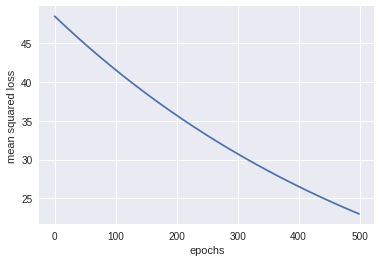

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# set requires_grad = True to track the gradients
weights = torch.randn(num_features, num_classes, device=device, requires_grad=True)

learning_rate = 2e-5
num_epochs = 500
losses = []
auto_grads = []

for epoch in range(num_epochs):
    preds = torch.mm(x_train, weights)
    loss = (preds - y_train).pow(2).mean()
    losses.append(loss.item())

    loss.backward()
    
    # make sure not to change gradients when using them to update
    with torch.no_grad():
      # access the gradient with weights.grad
      weights -= learning_rate * weights.grad
      auto_grads.append(weights.grad.tolist())
      
      # make sure to reset the gradient to 0 for our next calculation
      weights.grad.zero_()

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

We can confirm that our automatic gradients are the same as the ones we calculate manually

In [ ]:
import numpy as np
auto = np.array(auto_grads)
manual = np.array(manual_grads)
print('Are all gradients very similar? ', np.allclose(auto, manual))

Are all gradients very similar?  True


## PyTorch Optimizers

We can make our code even simpler by letting the library do the gradient updates as well! Using `torch.optim` we can choose from a variety of optimization strategies, and in this case, we can use regular `SGD`. We have to specify all the parameters we wish to optimize, so in this case it is just `weights`

Text(0,0.5,'mean squared loss')

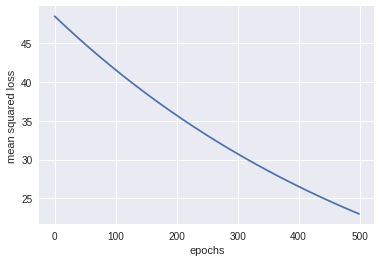

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
weights = torch.randn(num_features, num_classes, device=device, requires_grad=True)

learning_rate = 2e-5
# set the optimizer
optimizer = torch.optim.SGD([weights], lr=learning_rate)
num_epochs = 500
losses = []

for epoch in range(num_epochs):
    preds = torch.mm(x_train, weights)
    loss = (preds - y_train).pow(2).mean()

    losses.append(loss.item())

    # make sure to reset the gradients to 0 before calculation
    optimizer.zero_grad()
    
    loss.backward()
    
    # update our parameter with SGD
    optimizer.step()
    
    

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## PyTorch NN

Now nearly everything is in place, except it would still be a bit of a hassle to explicitly write out all the weights, biases, and other parameters we want to optimize. This is especially true since there are a lot of very common neural network building blocks that we use all the time. The `torch.nn` part of the libary is exactly that! It gives us all the tools to write our models at a higher level, going over the small details

Here, we will replace:
- `weights` with `nn.Linear` layer
- our optimizer's listing of parameters with `model.parameters()` 
- our manual loss calculation with `nn.MSELoss`


Text(0,0.5,'mean squared loss')

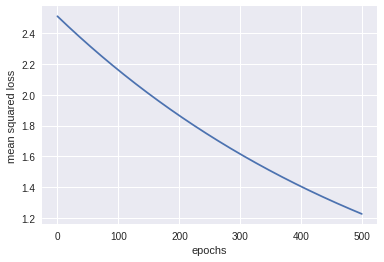

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# define your model
model = torch.nn.Linear(num_features, num_classes).to(device)
# choose a loss function
loss_fn = torch.nn.MSELoss()

num_epochs = 500
learning_rate = 2e-5
# automatically find all your model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    preds = model(x_train)
    loss = loss_fn(preds, y_train)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## PyTorch nn.Sequential
If we want more than one module/layer in a row, can put those layers together in [nn.Sequential](https://pytorch.org/docs/stable/nn.html?#sequential), which wraps them and turns them into one big module

Text(0,0.5,'mean squared loss')

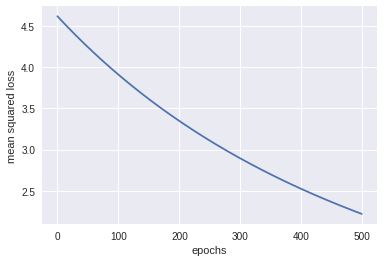

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 4),
    torch.nn.Linear(4, num_classes)
).to(device)
    
loss_fn = torch.nn.MSELoss()

num_epochs = 500
learning_rate = 2e-5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    preds = model(x_train)
    loss = loss_fn(preds, y_train)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## Challenge

We're now doing really well on the `iris` dataset mainly because it is so simple and neural networks are so powerful! Let's work on something a bit harder, and try our hands on the [`MNIST` dataset](https://en.wikipedia.org/wiki/MNIST_database). This dataset is one of the foundational datasets in computer vision!

There are 60,000 training and 10,000 test images. The input images are handwritten digits (0 - 9) in a 28x28 pixel grayscale image. This means the input is a Tensor of size `60000 x 28 x 28` where each value is an "intensity" (how dark the pixel is) number between 0 and 255 (inclusive) . The output is the number that this handwritten image is showing, so between 0 and 9.


We will revisit this later, so you don't need the details and most everything is set up but play around with the model, learning rate, and loss function to try and get as small an error as possible.

Here's some hints:
1. see the difference in speed between "cpu" and "cuda"
2. we changed the loss function to be softmax cross entropy (look [here](https://pytorch.org/docs/stable/nn.html?#loss-functions))
3. don't have too many layers (2-3 should be enough! ) but make sure to have enough hidden units (try making them all 100, then try varying each layer's individually)
4. put some [non-linearities](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) in between your linear layers 
4. look at your training and validation curve! remember important lessons about under/overfitting

In [ ]:
### CODE MODIFIED FROM PYTORCH EXAMPLE REPO ###

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

flatten = Flatten()

def train(model, device, train_loader, optimizer, epoch, loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(flatten(data))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(flatten(data))
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
# HYPERPARAMETERS TO PLAY WITH
    
device = torch.device("cuda")
# device = torch.device("cpu")

learning_rate = 0.01
batch_size = 64
epochs = 5

model = nn.Sequential(
    nn.Linear(784, 50),
    nn.Linear(50, 50),
    nn.Linear(50, 10),
).to(device)


optimizer = optim.SGD(model.parameters(), lr=learning_rate)


test_batch_size = 1000
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')


# data loading

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

# training

for epoch in range(1, epochs):
  train(model, device, train_loader, optimizer, epoch, loss_fn)
  test(model, device, test_loader, test_loss_fn)
